In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib import rcParams

In [2]:
def calc_angular_resolution(off_angle, trueE, q=0.68, erange=[0.01, 100], bins=10):
    '''
    off_angle - pd.Series
    true_e - pd.Series
    quantile - float
    erange - list, upper an lower edge in TeV
    ebins - int, number of bins
    '''

    ebins_log = np.linspace(np.log10(erange[0]), np.log10(erange[1]), bins+1)
    ebins = np.power(10, ebins_log)

    quantiles = np.zeros(shape=[2, bins])
    # loop over bins in energy
    for i in range(bins):

        angles_bin = off_angle.loc[(trueE >= ebins[i]) &\
                                   (trueE <= ebins[i+1])]
        N = len(angles_bin)

        quantiles[0, i] = angles_bin.quantile(q)
        # error of quantile follows binominal distribution
        quantiles[1, i] = np.sqrt(N * q * ( 1 - q)) / N

    # calculate mean positions 
    pos_log = np.mean(np.array([ebins_log[:-1], ebins_log[1:]]), axis=0)
    pos = np.power(10, pos_log)
    # get asymmetrical bin widths
    err = [pos - ebins[:-1], ebins[1:] - pos]

    return quantiles, pos, err

# Requirement

In [3]:
loge = [-1.64983, -1.49475, -1.32191, -1.05307, -0.522689, 
        0.139036, 0.949169, 1.67254,  2.20447, 2.49232]
e = np.power(10, loge)
angres = [0.453339 , 0.295111 , 0.203515 , 0.138619 , 0.0858772, 0.0569610, 0.0372988, 0.0274391, 0.0232297, 0.0216182]

# No Multiplicity cut

### Hyperarray

### Standardarray

# Cut in multiplicity

### Standard mutiplicity 5

### Multiplicity 4, comparison default weights with LUT weights

by default `weight = moments.intensity * (moments.length / moments.width)` is used.

In [4]:
max_files = None

#### Default weights, $N_{images} > 4$

In [5]:
datadir_default = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4/default_weights/")

data_default = None
for file in glob.glob("{}/output*gamma*".format(datadir_default))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_default = pd.concat([data_default, datafile])
    except NameError:
        data_default = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, $N_{images} > 4$

In [6]:
datadir_LUT = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4/LUT_weights/")

data_LUT = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT = pd.concat([data_LUT, datafile])
    except NameError:
        data_LUT = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$

In [7]:
datadir_LUT_ratiocut = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4/LUT_weights_ratiocut/")

data_LUT_ratiocut = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_ratiocut))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_ratiocut = pd.concat([data_LUT_ratiocut, datafile])
    except NameError:
        data_LUT_ratiocut = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut 2 per type and drop types

In [8]:
datadir_LUT_ratiocut_pertype = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/LUT_weights_ratiocut_removedTypes_0801/")

data_LUT_ratiocut_pertype = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_ratiocut_pertype))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_ratiocut_pertype = pd.concat([data_LUT_ratiocut_pertype, datafile])
    except NameError:
        data_LUT_ratiocut_pertype = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

/Users/konstantinpfrang/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


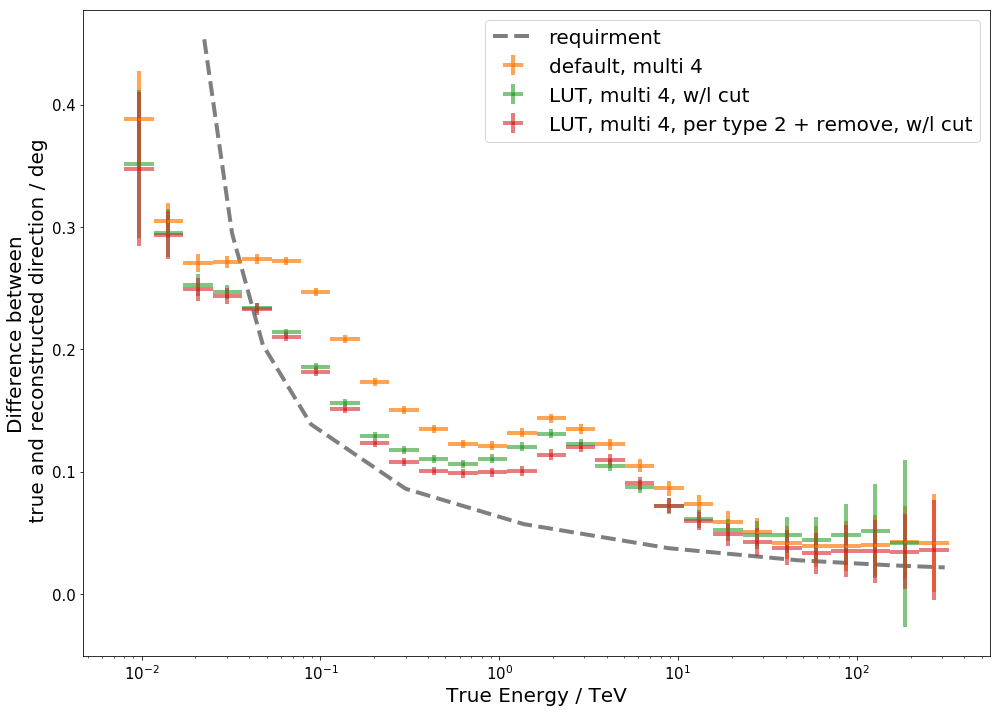

In [9]:
quantiles_default, pos, err_default = calc_angular_resolution(off_angle=data_default.off_angle,
                                  trueE=data_default.MC_Energy, erange=[0.008, 700], bins=30)

quantiles_LUT, pos, err_LUT = calc_angular_resolution(off_angle=data_LUT.off_angle,
                                  trueE=data_LUT.MC_Energy, erange=[0.008, 700], bins=30)

quantiles_LUT_ratiocut, pos, err_LUT_ratiocut = calc_angular_resolution(off_angle=data_LUT_ratiocut.off_angle,
                                  trueE=data_LUT_ratiocut.MC_Energy, erange=[0.008, 700], bins=30)

quantiles_LUT_ratiocut_pertype, pos, err_LUT_ratiocut_pertype = calc_angular_resolution(off_angle=data_LUT_ratiocut_pertype.off_angle,
                                  trueE=data_LUT_ratiocut_pertype.MC_Energy, erange=[0.008, 700], bins=30)


plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.ylim([0,.5])
plt.errorbar(pos, quantiles_default[0], quantiles_default[1], err_default, fmt="o", color="C1", zorder=10,
             label="default, multi 4", linewidth=4, markersize=2, alpha=0.7)
#plt.errorbar(pos, quantiles_LUT[0], quantiles_LUT[1], err_LUT, fmt="o", color="C0", zorder=10,
#             label="LUT, multi 4 ", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, quantiles_LUT_ratiocut[0], quantiles_LUT_ratiocut[1], err_LUT_ratiocut, fmt="o", color="C2", zorder=10,
             label="LUT, multi 4, w/l cut", linewidth=4, markersize=2, alpha=0.6)
plt.errorbar(pos, quantiles_LUT_ratiocut_pertype[0], quantiles_LUT_ratiocut_pertype[1], err_LUT_ratiocut_pertype, fmt="o", color="C3", zorder=10,
             label="LUT, multi 4, per type 2 + remove, w/l cut", linewidth=4, markersize=2, alpha=0.6)

plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Difference between\n true and reconstructed direction / deg", fontsize=20)

plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Standardarray_default_vs_LUT.pdf")

# Comparison of different multiplicity cuts

In [10]:
max_files = None

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) keep all if one passed

In [11]:
datadir_def_keep = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/defaultWeights_ratiocut_keepTypes_SST3_0801")

data_def_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_keep = pd.concat([data_def_keep, datafile])
    except NameError:
        data_def_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

OSError: HDF5 error back trace

  File "H5F.c", line 511, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1604, in H5F_open
    unable to read superblock
  File "H5Fsuper.c", line 630, in H5F__super_read
    truncated file: eof = 96, sblock->base_addr = 0, stored_eof = 2048

End of HDF5 error back trace

Unable to open/create file '/Users/konstantinpfrang/scratch_mount/software/CTA-analysis/Examples/write_feature_list/Output/Multiplicity4_perType/defaultWeights_ratiocut_keepTypes_SST3_0801/output_gamma_20deg_180deg_run218.h5'

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) remove types

In [ ]:
datadir_def_remove = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/defaultWeights_ratiocut_removedTypes_SST3_0801")

data_def_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_remove = pd.concat([data_def_remove, datafile])
    except NameError:
        data_def_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) keep all if one passed

In [ ]:
datadir_LUT_keep = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/LUT_weights_ratiocut_keepTypes_SST3_0801")

data_LUT_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_keep = pd.concat([data_LUT_keep, datafile])
    except NameError:
        data_LUT_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 3) remove types

In [ ]:
datadir_LUT_remove = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/LUT_weights_ratiocut_removedTypes_SST3_0801")

data_LUT_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_remove = pd.concat([data_LUT_remove, datafile])
    except NameError:
        data_LUT_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

In [ ]:
q_default_keep, pos, err_default_keep = calc_angular_resolution(off_angle=data_def_keep.off_angle,
                                  trueE=data_def_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_default_remove, pos, err_default_remove = calc_angular_resolution(off_angle=data_def_remove.off_angle,
                                  trueE=data_def_remove.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_keep, pos, err_LUT_keep = calc_angular_resolution(off_angle=data_LUT_keep.off_angle,
                                  trueE=data_LUT_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_remove, pos, err_LUT_remove = calc_angular_resolution(off_angle=data_LUT_remove.off_angle,
                                  trueE=data_LUT_remove.MC_Energy, erange=[0.008, 700], bins=30)


plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.ylim([0,.5])
plt.errorbar(pos, q_default_keep[0], q_default_keep[1], err_default_keep, fmt="o", color="C1", zorder=10,
             label="default\n{:1.1e} events passed".format(len(data_def_keep)), linewidth=4, markersize=2, alpha=0.7)
#plt.errorbar(pos, q_default_remove[0], q_default_remove[1], err_default_remove, fmt="o", color="C0", zorder=10,
#             label="default weights remove types ", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, q_LUT_keep[0], q_LUT_keep[1], err_LUT_keep, fmt="o", color="C2", zorder=10,
             label="LUT\n{:1.1e} events passed".format(len(data_LUT_keep)), linewidth=4, markersize=2, alpha=0.6)
plt.errorbar(pos, q_LUT_remove[0], q_LUT_remove[1], err_LUT_remove, fmt="o", color="C3", zorder=10,
             label="LUT, telescope types removed\n{:1.1e} events passed".format(len(data_LUT_remove)), linewidth=4, markersize=2, alpha=0.6)

plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Angular resolution / deg", fontsize=20)
plt.title(r"$N_{images}>4$, $N_{images, LST}>2$, $N_{images, MST}>2$, $N_{images, SST}>3$", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Standardarray_def_LUT_removed_telescopes.pdf")

# Comparison of different multiplicity cuts SST4

In [ ]:
max_files = None

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) keep all if one passed

In [ ]:
datadir_def_keep = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/SST4/default_keep")

data_def_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_keep = pd.concat([data_def_keep, datafile])
    except NameError:
        data_def_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### default weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) remove types

In [ ]:
datadir_def_remove = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/SST4/default_removed")

data_def_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_remove = pd.concat([data_def_remove, datafile])
    except NameError:
        data_def_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) keep all if one passed

In [ ]:
datadir_LUT_keep = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/SST4/LUT_keep")

data_LUT_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_keep = pd.concat([data_LUT_keep, datafile])
    except NameError:
        data_LUT_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

#### LUT weights, cut on ratio width / length, $N_{images} > 4$, cut per type 2 (SST 4) remove types

In [ ]:
datadir_LUT_remove = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/SST4/LUT_remove")

data_LUT_remove = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_remove))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_remove = pd.concat([data_LUT_remove, datafile])
    except NameError:
        data_LUT_remove = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

In [ ]:
q_default_keep, pos, err_default_keep = calc_angular_resolution(off_angle=data_def_keep.off_angle,
                                  trueE=data_def_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_default_remove, pos, err_default_remove = calc_angular_resolution(off_angle=data_def_remove.off_angle,
                                  trueE=data_def_remove.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_keep, pos, err_LUT_keep = calc_angular_resolution(off_angle=data_LUT_keep.off_angle,
                                  trueE=data_LUT_keep.MC_Energy, erange=[0.008, 700], bins=30)

q_LUT_remove, pos, err_LUT_remove = calc_angular_resolution(off_angle=data_LUT_remove.off_angle,
                                  trueE=data_LUT_remove.MC_Energy, erange=[0.008, 700], bins=30)


plt.figure(figsize=(14,10))
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
plt.xscale('log')
#plt.ylim([0,.5])
plt.errorbar(pos, q_default_keep[0], q_default_keep[1], err_default_keep, fmt="o", color="C1", zorder=10,
             label="default\n{:1.1e} events passed".format(len(data_def_keep)), linewidth=4, markersize=2, alpha=0.7)
#plt.errorbar(pos, q_default_remove[0], q_default_remove[1], err_default_remove, fmt="o", color="C0", zorder=10,
#             label="default weights remove types ", linewidth=4, markersize=2, alpha=0.7)
plt.errorbar(pos, q_LUT_keep[0], q_LUT_keep[1], err_LUT_keep, fmt="o", color="C2", zorder=10,
             label="LUT\n{:1.1e} events passed".format(len(data_LUT_keep)), linewidth=4, markersize=2, alpha=0.6)
plt.errorbar(pos, q_LUT_remove[0], q_LUT_remove[1], err_LUT_remove, fmt="o", color="C3", zorder=10,
             label="LUT, telescope types removed\n{:1.1e} events passed".format(len(data_LUT_remove)), linewidth=4, markersize=2, alpha=0.6)

plt.plot(e, angres, linewidth=4, label="requirment", color="k", alpha=0.5, linestyle="--")
plt.xlabel("True Energy / TeV", fontsize=20)
plt.ylabel("Angular resolution / deg", fontsize=20)
plt.title(r"$N_{images}>4$, $N_{images, LST}>2$, $N_{images, MST}>2$, $N_{images, SST}>4$", fontsize=20)
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig("Standardarray_def_LUT_removed_telescopes_SST4.pdf")

In [ ]:
max_files = 1

def read_files(filelist, max_files):
    np.random.shuffle(filelist)
    
    for file in filelist[:max_files]:
        datafile = pd.read_hdf(file, key="direction_reconstriction")
        try:
            data = pd.concat([data, datafile])
        except NameError:
            data = datafile
        except (HDF5ExtError, OSError):
            print("Not able to read {}".format(file))
            continue
    return len(data)
            
datadir_def_keep = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/SST4/default_keep")
filelist_def = glob.glob("{}/output*gamma*".format(datadir_def_keep))

datadir_LUT_keep = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/SST4/LUT_keep")
filelist_lut = glob.glob("{}/output*gamma*".format(datadir_LUT_keep))

ndef = []
nlut = []
for i in range(500):
    ndef.append(read_files(filelist_def, max_files))
    nlut.append(read_files(filelist_lut, max_files))
    
print("Default weights events per {} files: {}+-{}".format(max_files, np.mean(ndef), np.std(ndef)))
print("LUT weights events per {} files: {}+-{}".format(max_files, np.mean(nlut), np.std(nlut)))

In [ ]:
datadir_def_keep = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/SST4/default_keep")

data_def_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_def_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_def_keep = pd.concat([data_def_keep, datafile])
    except NameError:
        data_def_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

In [ ]:
datadir_LUT_keep = os.path.abspath("../../Examples/write_feature_list/Output/Multiplicity4_perType/SST4/LUT_keep")

data_LUT_keep = None
for file in glob.glob("{}/output*gamma*".format(datadir_LUT_keep))[:max_files]:
    datafile = pd.read_hdf(file, key="direction_reconstriction")
    try:
        data_LUT_keep = pd.concat([data_LUT_keep, datafile])
    except NameError:
        data_LUT_keep = datafile
    except (HDF5ExtError, OSError):
        print("Not able to read {}".format(file))
        continue

# Playground

In [ ]:
from ctapipe.io import event_source
import astropy.units as u
source = event_source("/Users/konstantinpfrang/CTAPIPE/gamma_cone/gamma_20deg_180deg_run1___cta-prod3_desert-2150m-Paranal-merged_cone10.simtel.gz")

In [ ]:
from ctapipe.coordinates import CameraFrame, HorizonFrame
from astropy.coordinates import SkyCoord

from ctapipe.visualization import CameraDisplay   # plot camera images
from ctapipe.io import event_source               # read rata
from ctapipe.calib import CameraCalibrator        # calibration from r0 to dl1
from ctapipe.calib.camera.gainselection import pick_gain_channel # gain selection
from ctapipe.image.cleaning import tailcuts_clean # image cleaning
from ctapipe.image import hillas_parameters       # parametrization
from traitlets.config import Config               # handeling of configurations
from ctapipe.io import EventSeeker
import pickle

# Analyze one file

In [ ]:
calibrator_cfg = Config()
calibrator_cfg["ChargeExtractorFactory"]["product"] = "LocalPeakIntegrator" # peak detection method
calibrator_cfg['WaveformCleanerFactory']['product'] = "NullWaveformCleaner" # waveform cleaning
calibrator_cfg["ChargeExtractorFactory"]["window_width"] = 7 # width of integration window
calibrator_cfg["ChargeExtractorFactory"]["window_shift"] = 3 # shift of integration window

calibrator = CameraCalibrator(r1_product="HESSIOR1Calibrator", config=calibrator_cfg)

# Thresholds for gain channel selection
pe_thresh = {
    "ASTRICam": 14,
    "LSTCam": 100,
    "NectarCam": 190}

# Ecample: get the DCA value

In [ ]:
source = event_source("/Users/konstantinpfrang/CTAPIPE/gamma_onSource/\
gamma_20deg_180deg_run1___cta-prod3_desert-2150m-Paranal-merged.simtel.gz",
                     max_events=20)

lookupdata = {}
columns = ["dca", "length", "width", "intensity"]

hillas_dict = {}

LUTgen = LookupGenerator()

for event in source:
    hillas_dict = {}
    calibrator.calibrate(event)
    
    for tel_id in event.r0.tels_with_data:

        camera = event.inst.subarray.tel[tel_id].camera

        if camera.cam_id in pe_thresh.keys():
            image, mask = pick_gain_channel(event.dl1.tel[tel_id].image,
                      pe_thresh[camera.cam_id], select_by_sample=True)
        else:
            image = np.squeeze(event.dl1.tel[tel_id].image)

        mask = tailcuts_clean(camera, image=image,
            min_number_picture_neighbors=2)

        if sum(mask) == 0:
            continue
        cleaned_image = np.copy(image) # copy of image
        cleaned_image[~mask] = 0 # setting not survived pixels to zero

        params = hillas_parameters(camera, cleaned_image)
        hillas_dict[tel_id] = params
    
    LUTgen.collect_data(event, hillas_dict)

In [ ]:
size_max = {"NectarCam": 500000,
    "FlashCam": 500000,
    "LSTCam": 1000000,
    "ASTRICam": 200000,
    "DigiCam": 50000,
    "CHEC": 50000}

LUT = LUTgen.make_lookup(size_max, bins=[10,10])

LUTgen.display_lookup()

In [ ]:
if round(5/2) < 5/2:
    

In [ ]:
%load_ext autoreload
%autoreload 2
from direction_LUT_module import *

rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
LUT = LookupGenerator.load("../../Examples/write_feature_list/ctapipe_aux_dir/direction_weights_LUT.json")
LUT.display_lookup()

In [ ]:
size_max = {
    "NectarCam": 2000000,
    "FlashCam": 2000000,
    "LSTCam": 10000000,
    "ASTRICam": 500000,
    "DigiCam": 50000,
    "CHEC": 50000}

LUT = LUTgen.make_lookup(size_max, bins=[5,5])

LUTgen.save("test10.json")

In [ ]:
import glob
f = glob.glob("../../Examples/write_feature_list/Output/make_LUT_0731/*.json")
a = LookupGenerator.combine_LUTs(f)
a.display_lookup()

In [ ]:
bins = np.linspace(0,4, 20)

plt.hist(np.array(dca)[np.isfinite(dca)], bins, histtype="step", linewidth=4, label="old")
plt.hist(dca2, bins, histtype="step", linewidth=4, label="new")
plt.legend()

In [ ]:
fig = plt.figure(figsize=[10,10])
ax=fig.add_subplot(111)
disp = CameraDisplay(camera, image)
plt.scatter(cam_coord.x.value, cam_coord.y.value, label="Direction in cam")
disp.overlay_moments(params, color="C1",linewidth=3, with_label=False, alpha=0.9)

dca, x_, y_ = calculate_dca((cam_coord.x, cam_coord.y), params, get_point=True)

def line(x, x_, y_, psi_):
    y0 = - np.tan(psi_) * x_ + y_
    return(np.tan(psi_) * x + y0)

x = np.linspace(-0.8, 0, 100)
y = line(x, params.x.value, params.y.value, params.psi.to(u.deg))

#y2 = line(x, cam_coord.x.value, cam_coord.y.value, 180*u.deg-params.psi.to(u.deg))
plt.plot(x,y, color="C1", label="Hillas larger semi-axis", alpha=0.9, linewidth=2)

plt.plot([x_.value, cam_coord.x.value], [y_.value, cam_coord.y.value], color="C0", linewidth=3)

plt.plot(x_.value, y_.value, color="C3", label="Intersection point", zorder=10, alpha=0.9,
         markersize=10, marker="^", linewidth=0)

plt.xlim([-1.2,0])
plt.ylim([0,1.2])
plt.legend(fontsize=20)

In [ ]:
from ctapipe.io.containers import HillasParametersContainer

In [ ]:
HillasParametersContainer()

In [ ]:
from collections import namedtuple

In [ ]:
features = namedtuple("dca", (
                "a",
                "b"
                ))

In [ ]:
f = features(a = 1,
        b = 2)

In [ ]:
f

In [ ]:
[[2]] + [[12]]

In [ ]:
for cam_id in ['LSTCam', 'FlashCam', 'DigiCam']:
	pd.read_hdf('../../Examples/write_feature_list/Output/Multiplicity4_perType/SST4/LUT_keep/output_gamma_20deg_0deg_run1.h5', "feature_events_{}".format(cam_id))

In [ ]:
"""
Line-intersection-based fitting.
Contact: Tino Michael <Tino.Michael@cea.fr>
"""


from ctapipe.reco.reco_algorithms import Reconstructor
from ctapipe.io.containers import ReconstructedShowerContainer
from ctapipe.coordinates import TiltedGroundFrame, HorizonFrame, CameraFrame
from astropy.coordinates import SkyCoord, spherical_to_cartesian, cartesian_to_spherical
from itertools import combinations

import numpy as np

from scipy.optimize import minimize

from astropy import units as u


__all__ = ['HillasReconstructor', 'TooFewTelescopesException', 'HillasPlane']


class TooFewTelescopesException(Exception):
    pass


def angle(v1, v2):
    """ computes the angle between two vectors
        assuming carthesian coordinates
    Parameters
    ----------
    v1 : numpy array
    v2 : numpy array
    Returns
    -------
    the angle between v1 and v2 as a dimensioned astropy quantity
    """
    norm = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.arccos(np.clip(v1.dot(v2) / norm, -1.0, 1.0))


def normalise(vec):
    """ Sets the length of the vector to 1
        without changing its direction
    Parameters
    ----------
    vec : numpy array
    Returns
    -------
    numpy array with the same direction but length of 1
    """
    try:
        return vec / np.linalg.norm(vec)
    except ZeroDivisionError:
        return vec


class HillasReconstructor(Reconstructor):
    """
    class that reconstructs the direction of an atmospheric shower
    using a simple hillas parametrisation of the camera images it
    provides a direction estimate in two steps and an estimate for the
    shower's impact position on the ground.
    so far, it does neither provide an energy estimator nor an
    uncertainty on the reconstructed parameters
    """

    def __init__(self, config=None, tool=None, **kwargs):
        super().__init__(config=config, parent=tool, **kwargs)
        self.hillas_planes = {}

    def predict(self, hillas_dict, inst, pointing_alt, pointing_az, seed_pos=(0, 0)):
        """The function you want to call for the reconstruction of the
        event. It takes care of setting up the event and consecutively
        calls the functions for the direction and core position
        reconstruction.  Shower parameters not reconstructed by this
        class are set to np.nan
        Parameters
        -----------
        hillas_dict : python dictionary
            dictionary with telescope IDs as key and
            HillasParametersContainer instances as values
        inst : ctapipe.io.InstrumentContainer
            instrumental description
        pointing_alt:
        pointing_az:
        seed_pos : python tuple
            shape (2) tuple with a possible seed for
            the core position fit (e.g. CoG of all telescope images)
        Raises
        ------
        TooFewTelescopesException
            if len(hillas_dict) < 2
        """

        # stereoscopy needs at least two telescopes
        if len(hillas_dict) < 2:
            raise TooFewTelescopesException(
                "need at least two telescopes, have {}"
                .format(len(hillas_dict)))

        self.inititialize_hillas_planes(
            hillas_dict,
            inst.subarray,
            pointing_alt,
            pointing_az
        )

        # algebraic direction estimate
        direction, err_est_dir, crossings = self.estimate_direction()
        
        # core position estimate using a geometric approach
        pos, err_est_pos = self.estimate_core_position()

        # container class for reconstructed showers
        result = ReconstructedShowerContainer()
        _, lat, lon = cartesian_to_spherical(*direction)

        # estimate max height of shower
        h_max = self.estimate_h_max(hillas_dict, inst.subarray, pointing_alt, pointing_az)


        result.alt, result.az = lat, lon
        result.core_x = pos[0]
        result.core_y = pos[1]
        result.core_uncert = err_est_pos

        result.tel_ids = [h for h in hillas_dict.keys()]
        result.average_size = np.mean([h.intensity for h in hillas_dict.values()])
        result.is_valid = True

        result.alt_uncert = err_est_dir
        result.az_uncert = np.nan

        result.h_max = h_max
        result.h_max_uncert = np.nan

        result.goodness_of_fit = np.nan

        return result, crossings

    def inititialize_hillas_planes(
        self,
        hillas_dict,
        subarray,
        pointing_alt,
        pointing_az
    ):
        """
        creates a dictionary of :class:`.HillasPlane` from a dictionary of
        hillas
        parameters
        Parameters
        ----------
        hillas_dict : dictionary
            dictionary of hillas moments
        subarray : ctapipe.instrument.SubarrayDescription
            subarray information
        tel_phi, tel_theta : dictionaries
            dictionaries of the orientation angles of the telescopes
            needs to contain at least the same keys as in `hillas_dict`
        """

        self.hillas_planes = {}
        for tel_id, moments in hillas_dict.items():
            p2_x = moments.x + 0.1 * u.m * np.cos(moments.psi)
            p2_y = moments.y + 0.1 * u.m * np.sin(moments.psi)
            focal_length = subarray.tel[tel_id].optics.equivalent_focal_length

            pointing = SkyCoord(
                alt=pointing_alt[tel_id],
                az=pointing_az[tel_id],
                frame='altaz'
            )

            hf = HorizonFrame(
                array_direction=pointing,
                pointing_direction=pointing
            )
            cf = CameraFrame(
                focal_length=focal_length,
                array_direction=pointing,
                pointing_direction=pointing
            )

            cog_coord = SkyCoord(x=moments.x, y=moments.y, frame=cf)
            cog_coord = cog_coord.transform_to(hf)

            p2_coord = SkyCoord(x=p2_x, y=p2_y, frame=cf)
            p2_coord = p2_coord.transform_to(hf)

            circle = HillasPlane(
                p1=cog_coord,
                p2=p2_coord,
                telescope_position=subarray.positions[tel_id],
                weight=moments.intensity * (moments.length / moments.width),
            )
            self.hillas_planes[tel_id] = circle

    def estimate_direction(self):
        """calculates the origin of the gamma as the weighted average
        direction of the intersections of all hillas planes
        Returns
        -------
        gamma : shape (3) numpy array
            direction of origin of the reconstructed shower as a 3D vector
        crossings : shape (n,3) list
            an error esimate
        """

        crossings = []
        for perm in combinations(self.hillas_planes.values(), 2):
            n1, n2 = perm[0].norm, perm[1].norm
            # cross product automatically weighs in the angle between
            # the two vectors: narrower angles have less impact,
            # perpendicular vectors have the most
            crossing = np.cross(n1, n2)
            # two great circles cross each other twice (one would be
            # the origin, the other one the direction of the gamma) it
            # doesn't matter which we pick but it should at least be
            # consistent: make sure to always take the "upper" solution
            if crossing[2] < 0:
                crossing *= -1

            crossings.append(crossing * perm[0].weight * perm[1].weight)
            
        result = normalise(np.sum(crossings, axis=0))
        off_angles = [angle(result, cross) for cross in crossings] * u.rad

        err_est_dir = np.average(
            off_angles,
            weights=[len(cross) for cross in crossings]
        )

        return result, err_est_dir, crossings



    def estimate_core_position(self):
        r"""calculates the core position as the least linear square solution
        of an (over-constrained) equation system
        Notes
        -----
        The basis is the "trace" of each telescope's `HillasPlane` which
        can be determined by the telescope's position P=(Px, Py) and
        the circle's normal vector, projected to the ground n=(nx,
        ny), so that for every r=(x, y) on the trace
        :math:`\vec n \cdot \vec r = \vec n \cdot \vec P` ,
        :math:`n_x \cdot x + n_y \cdot y = d`
        In a perfect world, the traces of all telescopes cross in the
        shower's point of impact. This means that there is one common
        point (x, y) for every telescope, so we can write in matrix
        form:
        .. math::
            :label: fullmatrix
            \begin{pmatrix}
                nx_1  &  ny_1  \\
                \vdots & \vdots \\
                nx_n  &  ny_n
            \end{pmatrix}
                \cdot (x, y) =
            \begin{pmatrix}
                d_1  \\
                \vdots \\
                d_n
            \end{pmatrix}
        or :math:`\boldsymbol{A} \cdot \vec r = \vec D` .
        Since we do not live in a perfect world and there probably is
        no point r that fulfils this equation system, it is solved by
        the method of least linear square:
        .. math::
            :label: rchisqr
            \vec{r}_{\chi^2} = (\boldsymbol{A}^\text{T} \cdot \boldsymbol{A})^{-1}
            \boldsymbol{A}^\text{T} \cdot \vec D
        :math:`\vec{r}_{\chi^2}` minimises the squared difference of
        .. math::
            \vec D - \boldsymbol{A} \cdot \vec r
        Weights are applied to every line of equation :eq:`fullmatrix`
        as stored in circle.weight (assuming they have been set in
        `get_great_circles` or elsewhere).
        Returns
        -------
        r_chisqr: numpy.ndarray(2)
            the minimum :math:`\chi^2` solution for the shower impact position
        pos_uncert: astropy length quantity
            error estimate on the reconstructed core position
        """

        A = np.zeros((len(self.hillas_planes), 2))
        D = np.zeros(len(self.hillas_planes))
        for i, circle in enumerate(self.hillas_planes.values()):
            # apply weight from circle and from the tilt of the circle
            # towards the horizontal plane: simply projecting
            # circle.norm to the ground gives higher weight to planes
            # perpendicular to the ground and less to those that have
            # a steeper angle
            A[i] = circle.weight * circle.norm[:2]
            # since A[i] is used in the dot-product, no need to multiply the
            # weight here
            D[i] = np.dot(A[i], circle.pos[:2])

        # the math from equation (2) would look like this:
        # ATA = np.dot(A.T, A)
        # ATAinv = np.linalg.inv(ATA)
        # ATAinvAT = np.dot(ATAinv, A.T)
        # return np.dot(ATAinvAT, D) * unit

        # instead used directly the numpy implementation
        # speed is the same, just handles already "SingularMatrixError"
        if np.all(np.isfinite(A)) and np.all(np.isfinite(D)):
            # note that NaN values create a value error with MKL
            # installations but not otherwise.
            pos = np.linalg.lstsq(A, D)[0] * u.m
        else:
            return [np.nan, np.nan], [np.nan, np.nan]

        weighted_sum_dist = np.sum([np.dot(pos[:2] - c.pos[:2], c.norm[:2]) * c.weight
                                    for c in self.hillas_planes.values()]) * pos.unit
        norm_sum_dist = np.sum([c.weight * np.linalg.norm(c.norm[:2])
                                for c in self.hillas_planes.values()])
        pos_uncert = abs(weighted_sum_dist / norm_sum_dist)

        return pos, pos_uncert



    def estimate_h_max(self, hillas_dict, subarray, pointing_alt, pointing_az):
        weights = []
        tels = []
        dirs = []

        for tel_id, moments in hillas_dict.items():

            focal_length = subarray.tel[tel_id].optics.equivalent_focal_length

            pointing = SkyCoord(
                alt=pointing_alt[tel_id],
                az=pointing_az[tel_id],
                frame='altaz'
            )

            hf = HorizonFrame(
                array_direction=pointing,
                pointing_direction=pointing
            )
            cf = CameraFrame(
                focal_length=focal_length,
                array_direction=pointing,
                pointing_direction=pointing
            )

            cog_coord = SkyCoord(x=moments.x, y=moments.y, frame=cf)
            cog_coord = cog_coord.transform_to(hf)

            cog_direction = spherical_to_cartesian(1, cog_coord.alt, cog_coord.az)
            cog_direction = np.array(cog_direction).ravel()

            weights.append(self.hillas_planes[tel_id].weight)
            tels.append(self.hillas_planes[tel_id].pos)
            dirs.append(cog_direction)

        # minimising the test function
        pos_max = minimize(dist_to_line3d, np.array([0, 0, 10000]),
                           args=(np.array(tels), np.array(dirs), np.array(weights)),
                           method='BFGS',
                           options={'disp': False}
                           ).x
        return pos_max[2] * u.m


def dist_to_line3d(pos, tels, dirs, weights):
    result = np.average(np.linalg.norm(np.cross((pos - tels), dirs), axis=1),
                        weights=weights)
    return result


class HillasPlane:
    """
    a tiny helper class to collect some parameters for each great great
    circle
    Stores some vectors a, b, and c
    These vectors are eucledian [x, y, z] where positive z values point towards the sky
    and x and y are parallel to the ground.
    """

    def __init__(self, p1, p2, telescope_position, weight=1):
        """The constructor takes two coordinates in the horizontal
        frame (alt, az) which define a plane perpedicular
        to the camera.
        Parameters
        -----------
        p1: astropy.coordinates.SkyCoord
            One of two direction vectors which define the plane.
            This coordinate has to be defined in the ctapipe.coordinates.HorizonFrame
        p2: astropy.coordinates.SkyCoord
            One of two direction vectors which define the plane.
            This coordinate has to be defined in the ctapipe.coordinates.HorizonFrame
        telescope_position: np.array(3)
            Position of the telescope on the ground
        weight : float, optional
            weight of this plane for later use during the reconstruction
        Notes
        -----
        c: numpy.ndarray(3)
            :math:`\vec c = (\vec a \times \vec b) \times \vec a`
            :math:`\rightarrow` a and c form an orthogonal base for the
            great circle
            (only orthonormal if a and b are of unit-length)
        norm: numpy.ndarray(3)
            normal vector of the circle's plane,
            perpendicular to a, b and c
        """

        self.pos = telescope_position

        self.a = np.array(spherical_to_cartesian(1, p1.alt, p1.az)).ravel()
        self.b = np.array(spherical_to_cartesian(1, p2.alt, p2.az)).ravel()

        # a and c form an orthogonal basis for the great circle
        # not really necessary since the norm can be calculated
        # with a and b just as well
        self.c = np.cross(np.cross(self.a, self.b), self.a)
        # normal vector for the plane defined by the great circle
        self.norm = normalise(np.cross(self.a, self.c))
        # some weight for this circle
        # (put e.g. uncertainty on the Hillas parameters
        # or number of PE in here)
        self.weight = weight

In [ ]:
from ctapipe.coordinates import CameraFrame, HorizonFrame
from astropy.coordinates import SkyCoord

from ctapipe.visualization import CameraDisplay   # plot camera images
from ctapipe.io import event_source               # read rata
from ctapipe.calib import CameraCalibrator        # calibration from r0 to dl1
from ctapipe.calib.camera.gainselection import pick_gain_channel # gain selection
from ctapipe.image.cleaning import tailcuts_clean # image cleaning
from ctapipe.image import hillas_parameters       # parametrization
from traitlets.config import Config               # handeling of configurations
from ctapipe.io import EventSeeker
import pickle

# Analyze one file

In [ ]:
calibrator_cfg = Config()
calibrator_cfg["ChargeExtractorFactory"]["product"] = "LocalPeakIntegrator" # peak detection method
calibrator_cfg['WaveformCleanerFactory']['product'] = "NullWaveformCleaner" # waveform cleaning
calibrator_cfg["ChargeExtractorFactory"]["window_width"] = 7 # width of integration window
calibrator_cfg["ChargeExtractorFactory"]["window_shift"] = 3 # shift of integration window

calibrator = CameraCalibrator(r1_product="HESSIOR1Calibrator", config=calibrator_cfg)

# Thresholds for gain channel selection
pe_thresh = {
    "ASTRICam": 14,
    "LSTCam": 100,
    "NectarCam": 190}

In [ ]:
import warnings
# some conflicts with numpy in HillasReconstructor (?)
# it should not spam the output:
warnings.simplefilter(action='ignore', category=FutureWarning)
# mouting RuntimeWarning for np.sqrt calculation
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [ ]:
from ctapipe.image.hillas import *

In [ ]:
source = event_source("/Users/konstantinpfrang/CTAPIPE/gamma_onSource/\
gamma_20deg_180deg_run1___cta-prod3_desert-2150m-Paranal-merged.simtel.gz",
                     max_events=500)



lookupdata = {}
columns = ["dca", "length", "width", "intensity"]

hillas_dict = {}
true_az = {}
true_alt = {}
not_reconstructed = 0
failed = {1: 0,
         2: 0,
         3: 0,
         4: 0,
         5: 0}
intensity = []
energy_failed = []
#for event in source:

#seeker = EventSeeker(source)
#event = seeker[10]

for event in source:  
    reconstructor = HillasReconstructor()
    hillas_dict = {}
    calibrator.calibrate(event)

    for tel_id in event.r0.tels_with_data:

        camera = event.inst.subarray.tel[tel_id].camera

        if camera.cam_id in pe_thresh.keys():
            image, mask = pick_gain_channel(event.dl1.tel[tel_id].image,
                      pe_thresh[camera.cam_id], select_by_sample=True)
        else:
            image = np.squeeze(event.dl1.tel[tel_id].image)

        mask = tailcuts_clean(camera, image=image,
            min_number_picture_neighbors=2)

        if sum(mask) == 0:
            continue
        cleaned_image = np.copy(image) # copy of image
        cleaned_image[~mask] = 0 # setting not survived pixels to zero
        
        
        for i, hillas_parameters in enumerate([hillas_parameters_4,
                          #hillas_parameters_2,
                          #hillas_parameters_3,
                          #hillas_parameters_4,
                              #hillas_parameters_5
                                              ]):
            try:
                params = hillas_parameters(camera, cleaned_image)
            except HillasParameterizationError:
                print("hillas_parameters_{}".format(4))
                print("failed")


            if np.isnan(params.width) or (params.width == 0.0 * u.m):
                not_reconstructed += 1
                print("hillas_parameters_{}".format(i+1))
                print("size: ", params.intensity)
                print("length: ", params.length)
                print("width: ", params.width)

                fig = plt.figure(figsize=[4,4])
                disp = CameraDisplay(camera, cleaned_image)
                disp.overlay_moments(params, color="r")
                disp.highlight_pixels(np.ones(len(mask), dtype=bool), color="w", alpha=0.5)
                xlim = [params.x /u.m - 0.1 , params.x/u.m + 0.1]
                plt.xlim(xlim)
                ylim = [params.y/u.m - 0.1 , params.y/u.m + 0.1]
                plt.ylim(ylim)
                #plt.show()
                intensity.append(params.intensity)

        hillas_dict[tel_id] = params
        true_az[tel_id] = event.mc.tel[tel_id].azimuth_raw * u.rad
        true_alt[tel_id] = event.mc.tel[tel_id].altitude_raw * u.rad
        
    try:
        reco_result = reconstructor.predict(hillas_dict,
                event.inst, true_alt, true_az)
    except TooFewTelescopesException:
        continue




In [ ]:
not_reconstructed

In [ ]:
np.array([0]*len(mask))

In [ ]:
camera = event.inst.subarray.tel[tel_id].camera

In [ ]:
params.x